<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [56]:
# Set your student number
student_number = 400101356
Name = 'Ali'
Last_Name = 'Soltani'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [57]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing Libraries

In [58]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [59]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [60]:
num_classes = len(train_set.classes)
input_dim = len(train_set.data[0]) * len(train_set.data[0][0])
print("Number of classes:", num_classes)
print("Input dimention:", input_dim)

Number of classes: 10
Input dimention: 784


In [61]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

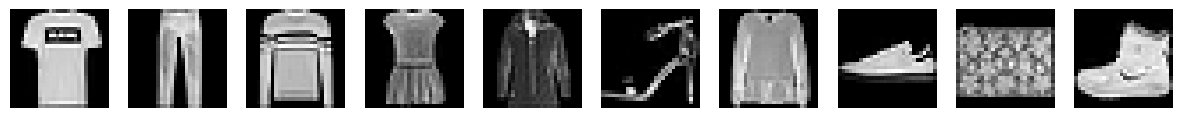

In [62]:
_, axs = plt.subplots(1, number_of_classes, figsize=(15, 10))
for i in range(number_of_classes):
    idxs = torch.where(train_set.targets == i)[0]
    img = train_set[idxs[0]][0].squeeze().numpy()
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [63]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [64]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [65]:
def affine_forward(x, w, b):
    return x @ w + b

def relu(x):
    return torch.maximum(x, torch.zeros_like(x))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [66]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    
    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']
        x = affine_forward(x, w, b)
        if (i < num_layers - 1):
            x = relu(x)
    output = x
    
    return output

Implementing cross entropy loss:

In [67]:
def cross_entropy_loss(scores, y):
    n = len(y)

    # Subtract max score for numerical stability
    max_scores = torch.max(scores, dim=1, keepdim=True)[0]
    stabilized_scores = scores - max_scores
    # Compute the exponentials of the stabilized scores
    exp_scores = torch.exp(stabilized_scores)
    # Compute the probabilities (softmax)
    sum_exp_scores = torch.sum(exp_scores, dim=1, keepdim=True)
    probs = exp_scores / sum_exp_scores
    # Gather the log probabilities of the correct classes
    log_probs = torch.log(probs)
    correct_logprobs = -log_probs[range(n), y]
    # Compute the cross-entropy loss
    loss = torch.sum(correct_logprobs) / n

    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [68]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''

    for parameter in parameters.values():
        if parameter.grad is not None:
            # Update the parameter value
            parameter.data -= learning_rate * parameter.grad.data
            # Zero the gradients
            parameter.grad.zero_()


Training functions:

In [69]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    acc = np.sum(y_pred == y_true) / len(y_true)
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using backward method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)
        
        # Calculating the loss based on the model output
        loss = cross_entropy_loss(p, y)
        # Updating the gradients using backward method
        loss.backward()
        # Optimizing the model parameters using the sgd_optimizer function defined previously
        sgd_optimizer(parameters, learning_rate)
        train_loss += loss.item() * x.size(0)
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc:.4f}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch
    
    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        # Calculating the loss using the model output
        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc:.4f}')

    return total_loss, acc

In [70]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [71]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        print("Epoch", epoch, ":")
        train_loss, train_accuracy = train(train_loader, learning_rate, epoch)
        test_loss, test_accuracy = validate(test_loader, epoch, 'test')
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f'Loss of train set : {train_loss:.5f}')
        print(f'Loss of test set : {test_loss:.5f}')

    ## plot the loss history of training and test sets 
    plt.figure(figsize=(12, 4))
    plt.plot(range(num_epochs), train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History of Training Set')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.plot(range(num_epochs), test_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History of Test Set')
    plt.grid(True)
    plt.show()

    ## plot the accuracy history of training and test sets
    plt.figure(figsize=(12, 4))
    plt.plot(range(num_epochs), train_accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History of Training Set')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.plot(range(num_epochs), test_accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History of Test Set')
    plt.grid(True)
    plt.show()

Epoch 0 :
Accuracy of train set: 0.3184
Accuracy of test set: 0.4718
Loss of train set : 136862.72533
Loss of test set : 0.20985
Epoch 1 :
Accuracy of train set: 0.4144
Accuracy of test set: 0.4118
Loss of train set : 115823.93971
Loss of test set : 0.13213
Epoch 2 :
Accuracy of train set: 0.5452
Accuracy of test set: 0.5792
Loss of train set : 68443.20212
Loss of test set : 0.09370
Epoch 3 :
Accuracy of train set: 0.6368
Accuracy of test set: 0.6899
Loss of train set : 54314.25544
Loss of test set : 0.07797
Epoch 4 :
Accuracy of train set: 0.6932
Accuracy of test set: 0.7125
Loss of train set : 47629.61050
Loss of test set : 0.07047
Epoch 5 :
Accuracy of train set: 0.7314
Accuracy of test set: 0.7403
Loss of train set : 42888.31156
Loss of test set : 0.06457
Epoch 6 :
Accuracy of train set: 0.7619
Accuracy of test set: 0.7703
Loss of train set : 39459.99210
Loss of test set : 0.05981
Epoch 7 :
Accuracy of train set: 0.7793
Accuracy of test set: 0.7709
Loss of train set : 36979.36709
L

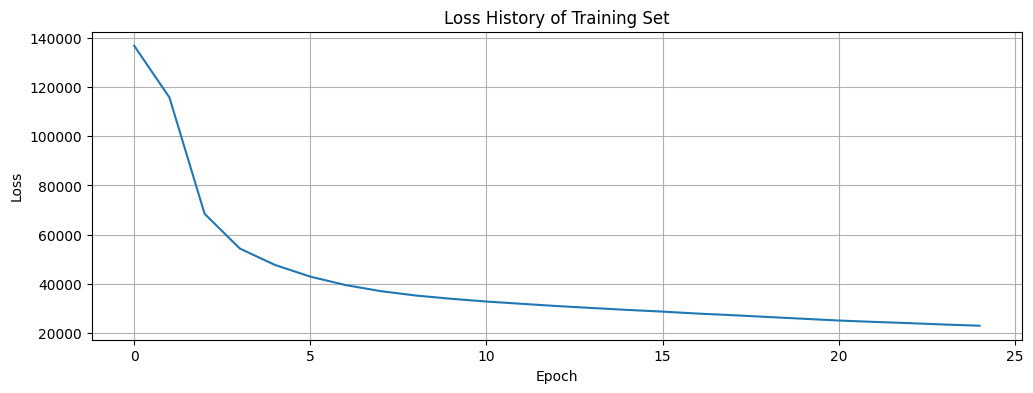

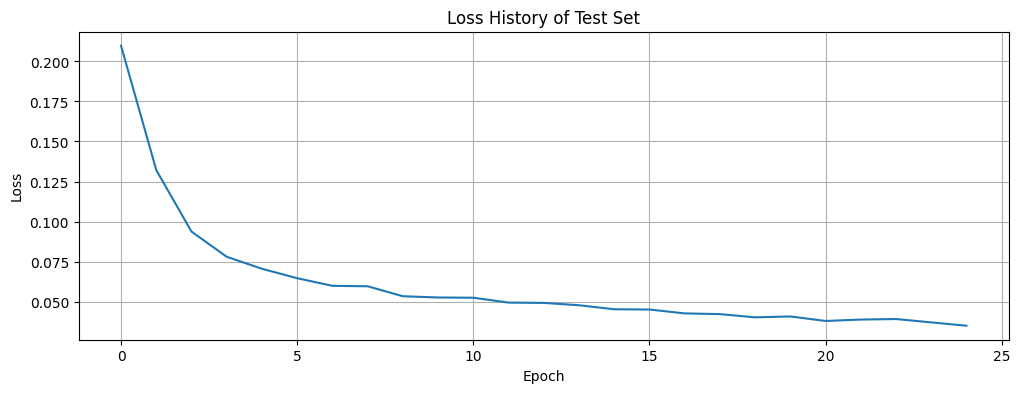

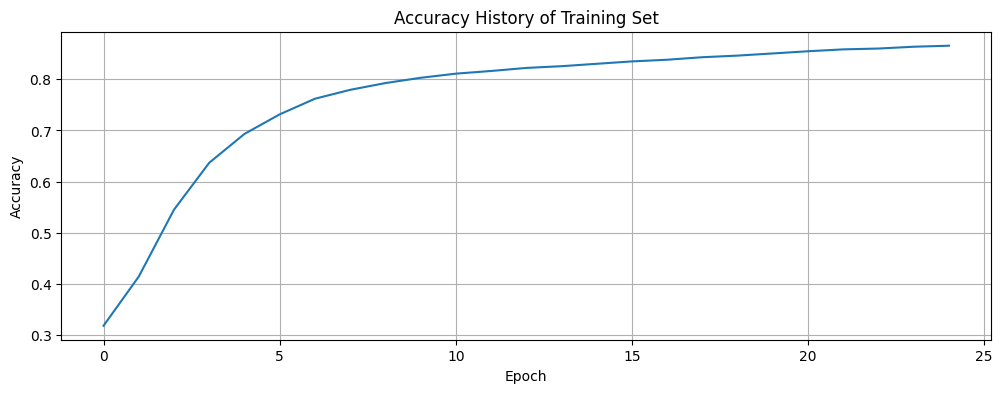

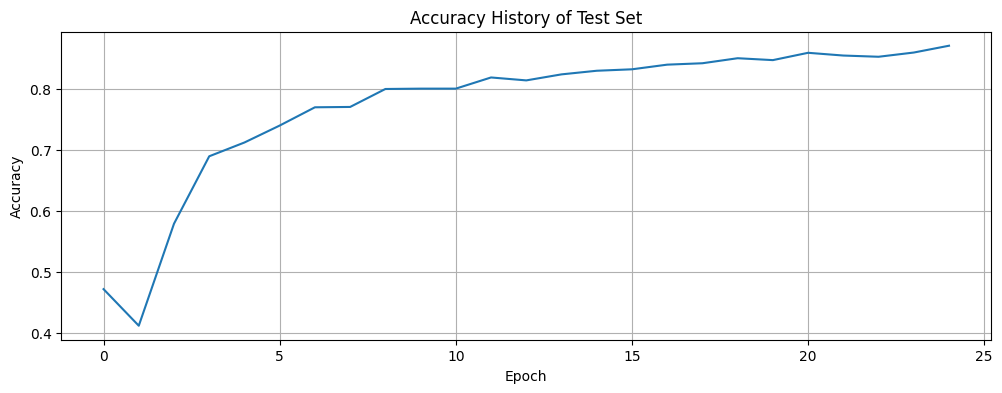

In [72]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [73]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8713333333333333


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

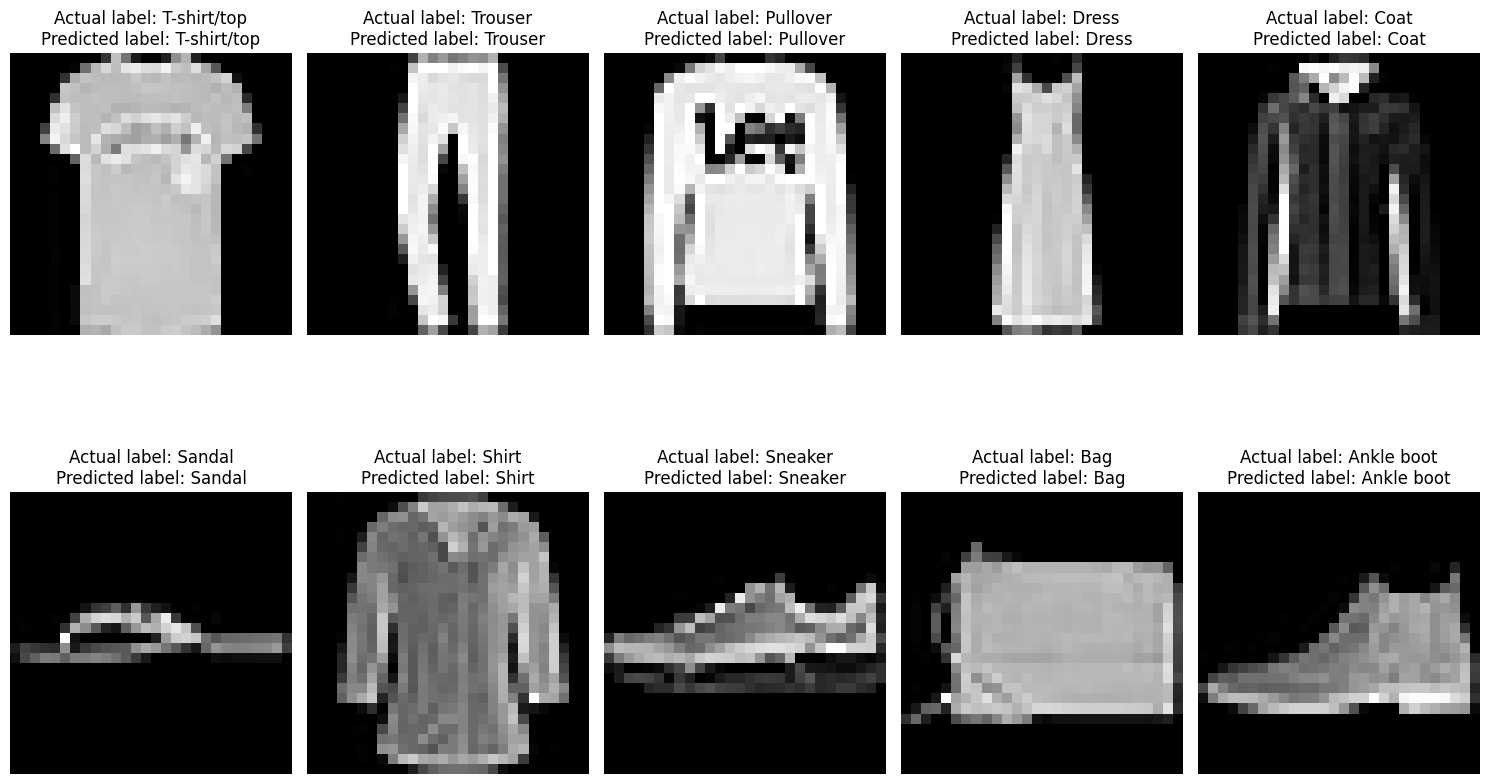

In [74]:
_, axs = plt.subplots(2, number_of_classes // 2, figsize=(15, 10))

for i in range(number_of_classes):
    idxs = torch.where(test_set.targets == i)[0]
    img = test_set[idxs[0]][0].squeeze().numpy()
    actual_label = test_set.classes[i]
    # Prepare image for the model
    img_tensor = test_set[idxs[0]][0].unsqueeze(0).to(device)  # Add batch dimension and move to device
    # Get the model's prediction
    with torch.no_grad():
        output = model(img_tensor, parameters)
        predicted_label_idx = torch.argmax(output, dim=1).item()
        predicted_label = test_set.classes[predicted_label_idx]
    ax = axs[i // (number_of_classes // 2), i % (number_of_classes // 2)]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Actual label: {actual_label}\nPredicted label: {predicted_label}")

plt.tight_layout()
plt.show()
